# Evaluation of the predicted Occupation

we use the exported `.csv` of our `predictiveParking` and compare it with the true values.

In [81]:
#!rm -rf parken_dump.csv
#!wget http://ubahn.draco.uberspace.de/opendata/dump/parken_dump.csv

In [82]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

In [83]:
# function to plot timeseries with weekend
def plotbelegung(df, which, fromdate, todate):
    if fromdate=='':
        fromdate=df.index[0]
    if todate=='':
        todate=df.index[-1]
        
    weekend = df[fromdate:todate].index[df[fromdate:todate].index.weekday>4]
    ax = df[fromdate:todate][which].plot(figsize=(9,6), ylim=(0, 130), alpha=0.9, rot=0, title='Auslastung Parkhaus Centrum Galerie Dresden %s bis %s' % (fromdate, todate))
    
    if not df.index.freqstr: # Wenn DataFrame keine Frequenz hat
        ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0,1,2,3,4,5,6),interval=2))
        ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=(0),interval=1))
        ax.xaxis.set_minor_formatter(dates.DateFormatter('%d.'))
        ax.xaxis.set_major_formatter(dates.DateFormatter('\nSa/So'))
        ax.xaxis.grid(True, which="minor")
        ax.xaxis.grid(False, which="major")
    
    plt.ylabel('%')
    
    for w in weekend[::10]:
        plt.axvline(w, c='k', alpha=0.08, zorder=-1)
        
    return plt

In [84]:
data = pd.read_csv('parken_dump.csv', encoding='latin1')

In [85]:
data['Belegung'] = 100.0-data['free']/data['count']*100.0

In [86]:
ppDD = data.pivot(index='time', columns='name', values='Belegung')

In [87]:
# Define index and names
ppDD.index = pd.DatetimeIndex(ppDD.index)
ppDD.index.name = 'Zeit'
ppDD.columns.name = 'Parkplatz'

print('Daten von %s/%s bis %s/%s' % (ppDD.index[0].month, ppDD.index[0].year, ppDD.index[-1].month, ppDD.index[-1].year)) 

Daten von 4/2014 bis 5/2015


### Machine Learning Model was trained with data until 2015-04-13, so we evaluate with the days after

In [88]:
ppDD = ppDD['2015-04-14':]

In [89]:
# format the percent without digits
ppDD = ppDD.applymap(lambda x: float('%.0f' % x))

# and limit it between 0...100%
ppDD = ppDD.applymap(lambda x: min(max(x, 0.0), 100.0))

In [90]:
centrumGalerie = ppDD[['Centrum-Galerie']].dropna()

In [91]:
centrumGalerie.index = [idx.replace(second=0) for idx in centrumGalerie.index]

In [92]:
centrumGalerie.head()

Parkplatz,Centrum-Galerie
2015-04-14 00:00:00,11
2015-04-14 00:15:00,11
2015-04-14 00:30:00,11
2015-04-14 00:45:00,11
2015-04-14 01:00:00,11


### Read the predicted data

In [93]:
prediction = pd.read_csv('Centrum-Galerie-Belegung-Vorhersage-2015-30min.csv', index_col=[0], skiprows=1, parse_dates=True, names=['Centrum-Galerie (Predicted)'])

### Join with the real data

In [94]:
compare = centrumGalerie.join(prediction)
compare.dropna(how='any', inplace=True)

In [95]:
compare.head(5)

,Centrum-Galerie,Centrum-Galerie (Predicted)
2015-04-14 01:30:00,11,20
2015-04-14 02:00:00,11,20
2015-04-14 02:30:00,11,20
2015-04-14 03:00:00,11,20
2015-04-14 03:30:00,11,20


<module 'matplotlib.pyplot' from '/Users/paul/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

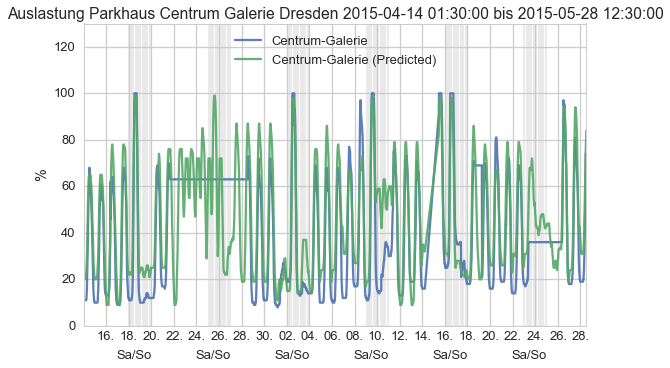

In [96]:
plotbelegung(compare, ['Centrum-Galerie','Centrum-Galerie (Predicted)'],'','')